# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
from relaxed.plot_defaults import *

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import sklearn
import scipy
import warnings
from tqdm import tqdm

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [5]:
from relaxed.analysis import get_mah, fit_hearin_params, get_t_from_a, transform_diffmah, alpha_diffmah, diffmah_analysis
from relaxed.models import training_suite, prepare_datasets
from relaxed import halo_catalogs


# Data

In [6]:
mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [7]:
ma_peak = mah_data['ma_peak']
scales = mah_data['scales']
t = get_t_from_a(scales)
t0 = get_t_from_a(1)

# Lmfit

In [8]:
tau_c, alpha_early, alpha_late = diffmah_analysis(ma_peak, scales)

Fitting Diffmah parameters: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.29it/s]


[4173 1510 3668 4494 9360 6313 3557 6939 9529]


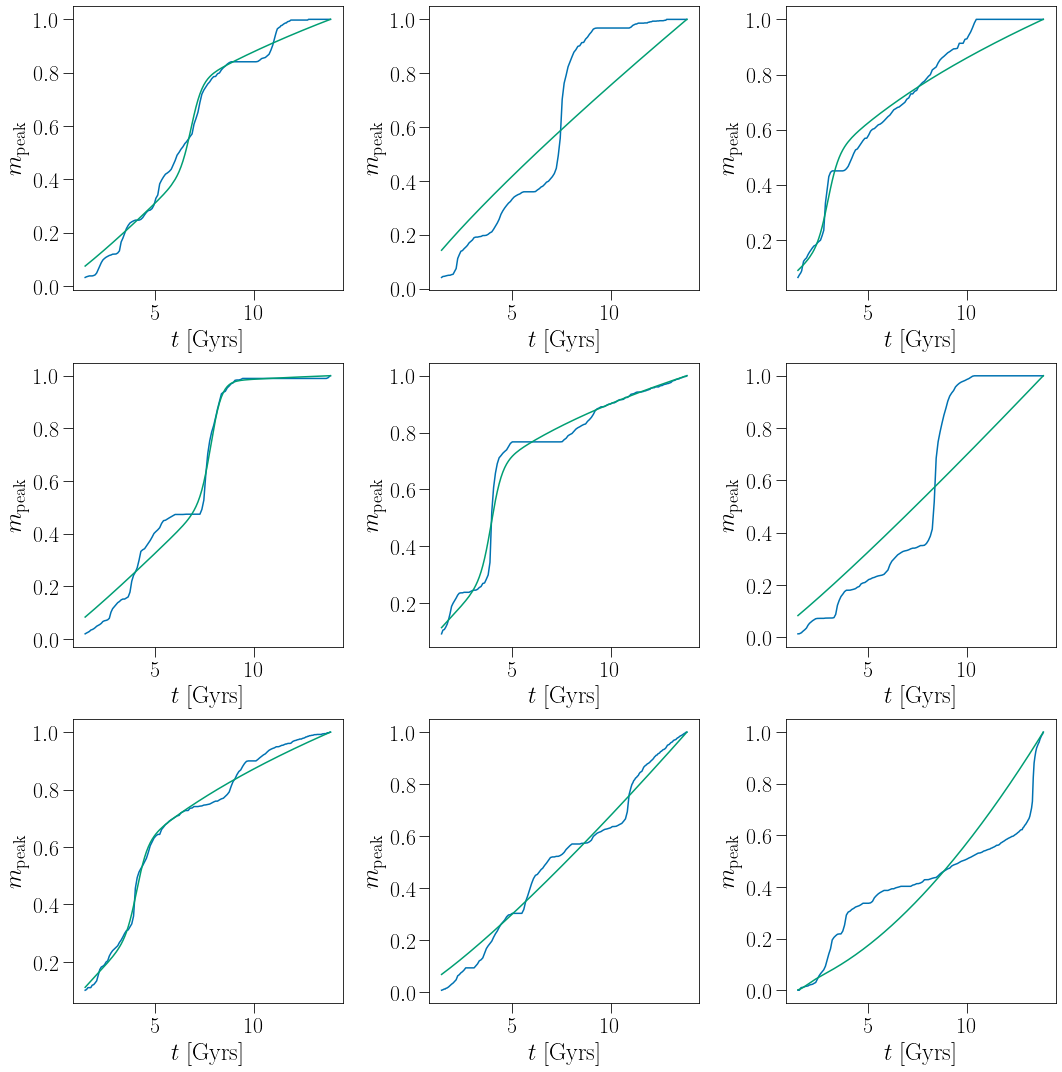

In [52]:
indices = np.random.randint(0, 10000, 9)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
print(indices)
for idx, ax in zip(indices, axes.flatten()): 
    pred = (t/t0)**(alpha_diffmah(t, tau_c[idx], alpha_early[idx], alpha_late[idx]))
    ax.plot(t, ma_peak[idx])
    ax.plot(t, pred)
    ax.set_xlabel(r"$t \; [\rm Gyrs]$")
    ax.set_ylabel(r"$m_{\rm peak}$")
plt.tight_layout()

Text(0.5, 0, '$\\log \\tau_{c} \\; [\\rm Gyr]$')

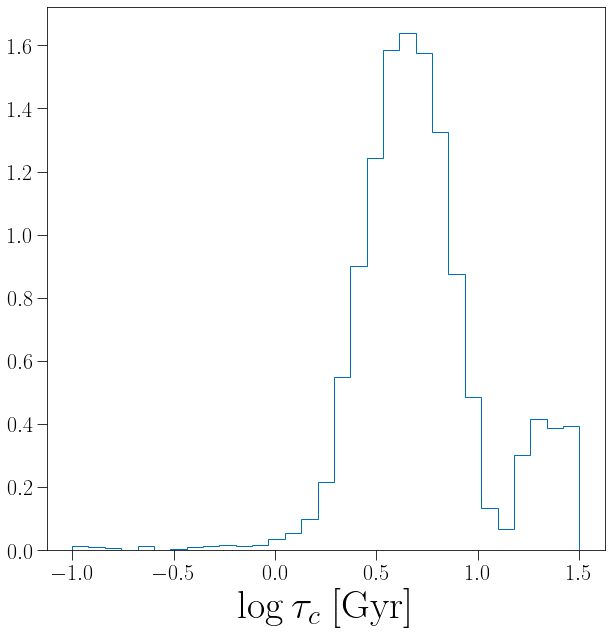

In [51]:
plt.hist(np.log10(tau_c), range=(-1, 1.5), bins=31, density=True, histtype='step')
plt.xlabel(r"$\log \tau_{c} \; [\rm Gyr]$", fontsize=40)

# Diffmah directly

In [2]:
from diffmah.fit_mah_helpers import get_loss_data
from diffmah.fit_mah_helpers import log_mah_mse_loss_and_grads
from diffmah.utils import jax_adam_wrapper

AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

In [ ]:
import jax